In [1]:
id_ = 'Goveia_Carmeliet_2020_NSCLC'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'

# Cell Type Verification

## Libraries and Data

We want to check our tumor vs normal classifier. For that we will explore the state of our cells by different methods.

1. Via UMAP, how the types of cell cluster vs the tumor and normal labels. Also, if it is normal adjacent or tumor. Sample labels to discard batch effects.
2. Marker genes plots for these comparisons per cell type: (**TypeNormalPred_HT** vs **REST**) (**TypeNormalPred_TT** vs **REST**) (**TypeNormalPred_HT** vs **TypeNormalPred_TT**)
   (**TypeTumorPred_TT** vs **REST**) (**TypeTumorPred_TT** vs **TypeNormalPred_TT**)
3. Heatmaps With the above groups (**TumorPred_TT**, **NormalPred_TT**, **NormalPred_HT**) as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
4. Prevalent gene ontologies for each of the groups above, considering also hallmark ontologies

In [3]:
import os
from pathlib import Path
import gdown

import sys
sys.path.append("..") 
from utils.functions import rank_genes_group

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects

# Set the graphics device
robjects.r('options(bitmapType="cairo")')
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/tmp/ipykernel_106/3462068993.py:33: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
%%R
library(edgeR)

Loading required package: limma


In [5]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 56281 × 18450
    obs: 'patient', 'condition', 'origin', 'Endothelial cell', 'Cluster', 'tissue', 'sample', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Types from infercnv dir

In [6]:
types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
types = types.rename(columns={'Unnamed: 0':'Observation'})
types = types.rename(columns={'Level_2_transfered_label':'cell_type'})
types

,Observation,cell_type
0,AAACCTGAGAGCTATA.2.NEC,Myeloid
1,AAACCTGAGCTAAGAT.2.NEC,Myeloid
2,AAACCTGAGGACCACA.2.NEC,Myeloid
3,AAACCTGAGGCCGAAT.2.NEC,Lymphoid
4,AAACCTGAGGTGACCA.2.NEC,Myeloid
...,...,...
51942,TTTGGTTTCTTGTACT.9.TEC,Blood vessels
51943,TTTGTCAAGTAGATGT.9.TEC,Blood vessels
51944,TTTGTCACAGGAATGC.9.TEC,Myeloid
51945,TTTGTCAGTAATCACC.9.TEC,Lymphatic EC


In [7]:
adata.obs = adata.obs.reset_index()
adata.obs = pd.merge(adata.obs, types, on='Observation',
                    how='left')
adata.obs.cell_type = adata.obs.cell_type.fillna('Unknown')
adata.obs.columns

Index(['Observation', 'patient', 'condition', 'origin', 'Endothelial cell',
       'Cluster', 'tissue', 'sample', 'n_counts', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'cell_type'],
      dtype='object')

### Tumor prediction from ikarus

In [8]:
preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
preds

,Unnamed: 0,final_pred
0,0,Normal
1,1,Normal
2,2,Normal
3,3,Normal
4,4,Normal
...,...,...
56276,56276,Normal
56277,56277,Normal
56278,56278,Normal
56279,56279,Normal


In [9]:
adata.obs['final_pred'] = list(preds.iloc[:,1])

In [14]:
adata.layers['counts'] = adata.X

## UMAP Clusters

We see similarities between cell types in normal tisse and tumor tissue. And  also what cell types are tumoral.

In [12]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [13]:
# adata = adata[adata.obs['final_pred']=='Tumor']
adata_normal = adata[adata.obs['origin']=='normal_adjacent']
adata_tumor = adata[adata.obs['origin']=='tumor_primary']

In [15]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)

2024-01-23 17:50:00.927205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 17:50:00.927429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 17:50:01.006307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 17:50:01.170502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 17:50:02.782041: W tensorflow/comp

In [16]:
sc.tl.umap(adata)

In [17]:
# sc.tl.leiden(adata_normal, resolution=0.4)
# sc.tl.leiden(adata_tumor, resolution=0.4)

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

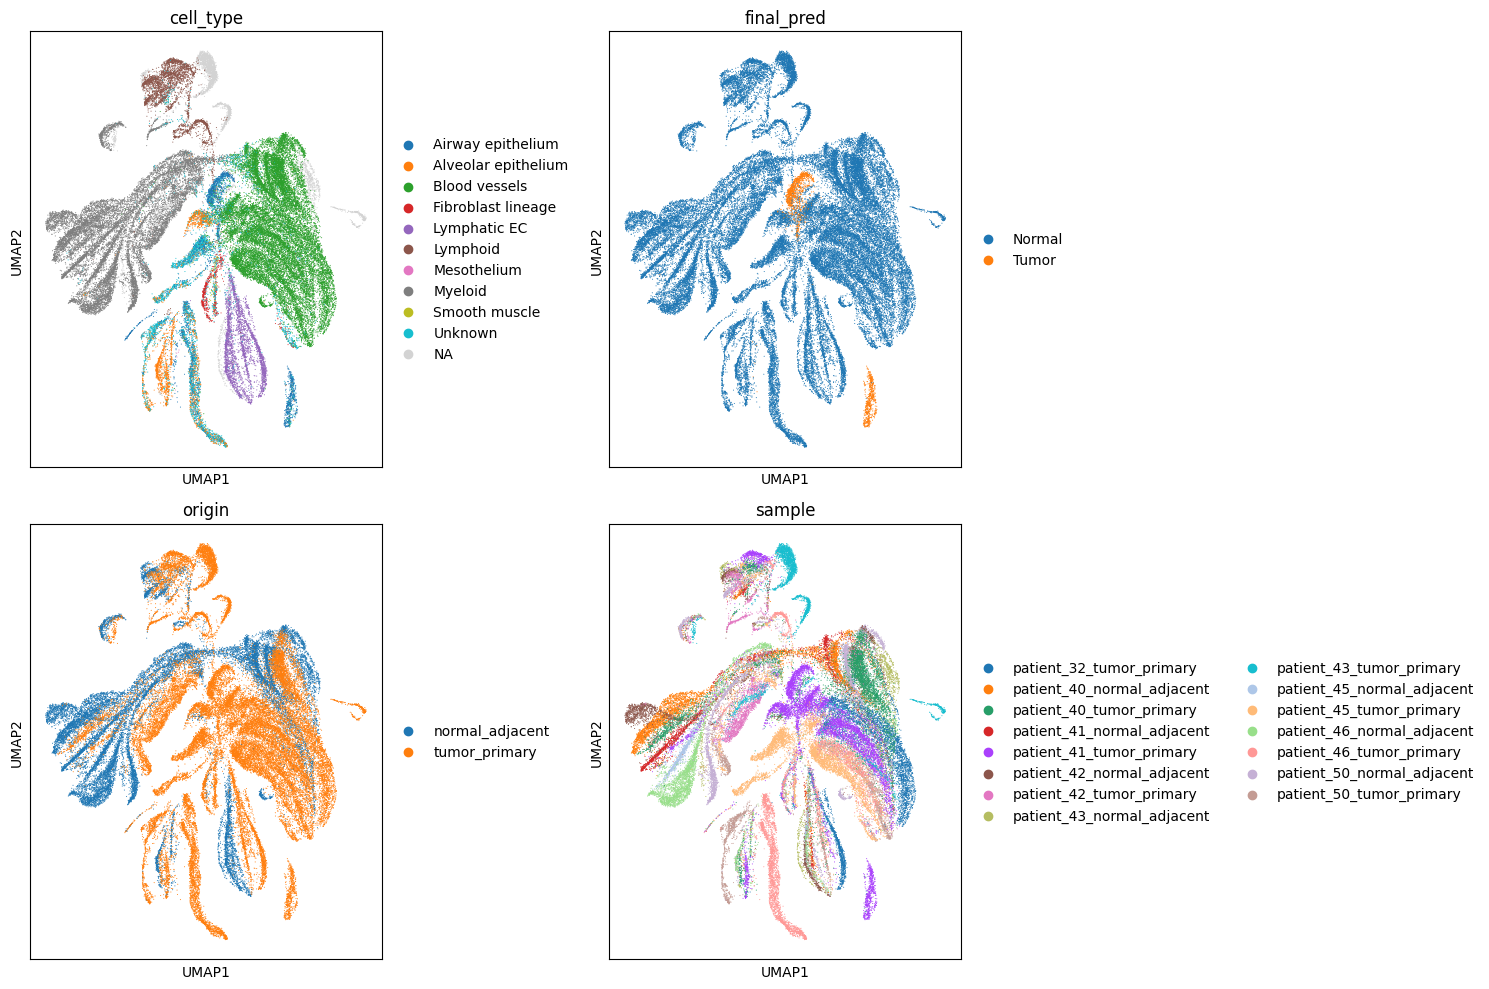

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sc.pl.umap(
    adata,
    color="cell_type",
    # legend_loc="on data",
    legend_fontoutline=2,
    ax=axs[0, 0],  # Specifies the subplot
    show=False  # Prevents showing the plot immediately
)

sc.pl.umap(
    adata,
    color="final_pred",
    # legend_loc="on data",
    legend_fontoutline=2,
    ax=axs[0, 1],  # Specifies the subplot
    show=False  # Prevents showing the plot immediately
)

sc.pl.umap(
    adata,
    color="origin",
    # legend_loc="on data",
    legend_fontoutline=2,
    ax=axs[1, 0],  # Specifies the subplot
    show=False  # Prevents showing the plot immediately
)

sc.pl.umap(
    adata,
    color="sample",
    # legend_loc="on data",
    legend_fontoutline=2,
    ax=axs[1, 1],  # Specifies the subplot
    show=False  # Prevents showing the plot immediately
)

# Display the entire figure with all plots
plt.tight_layout()
plt.show()

We can see that for the 'Tumor' prediciton there are mostly cells from patient 41, although there are many more samples from primary tumor.
This could be due to batch effects. So it is worthwile to run the prediction again with batch correction.

In [21]:
# adata.obs.groupby('leiden').count()
adata.obs.groupby('sample').count().iloc[:,0]

/tmp/ipykernel_113175/2910804369.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample').count().iloc[:,0]


sample
patient_32_tumor_primary      4830
patient_40_normal_adjacent    5023
patient_40_tumor_primary      5064
patient_41_normal_adjacent    2108
patient_41_tumor_primary      7483
patient_42_normal_adjacent    3487
patient_42_tumor_primary      2215
patient_43_normal_adjacent    1486
patient_43_tumor_primary      2848
patient_45_normal_adjacent    1720
patient_45_tumor_primary      5387
patient_46_normal_adjacent    3877
patient_46_tumor_primary      4401
patient_50_normal_adjacent    2971
patient_50_tumor_primary      3381
Name: Observation, dtype: int64

## Marker Genes

Create a column that merges cell type, tissue and tumor pred

In [45]:
adata.obs['type_tissue'] = adata.obs.apply(lambda x: str(x['cell_type']) + '_' + 
                 ('HT' if x['origin'] == 'normal_adjacent' else 'TT') + 
                 '_' + x['final_pred'], axis=1)
adata.obs['type_tissue'] = adata.obs['type_tissue'].astype('category')
adata.obs['type_tissue']

0              Myeloid_HT_Normal
1              Myeloid_HT_Normal
2              Myeloid_HT_Normal
3             Lymphoid_HT_Normal
4              Myeloid_HT_Normal
                  ...           
56276    Blood vessels_HT_Normal
56277    Blood vessels_HT_Normal
56278          Myeloid_HT_Normal
56279     Lymphatic EC_HT_Normal
56280    Blood vessels_HT_Normal
Name: type_tissue, Length: 56281, dtype: category
Categories (28, object): ['Airway epithelium_HT_Normal', 'Airway epithelium_HT_Tumor', 'Airway epithelium_TT_Normal', 'Airway epithelium_TT_Tumor', ..., 'Smooth muscle_TT_Normal', 'Unknown_HT_Normal', 'Unknown_TT_Normal', 'Unknown_TT_Tumor']

In [46]:
# We dont get them with unique because it saves the NaN's
types = adata.obs.cell_type.cat.categories
num_types = len(types)
types

Index(['Airway epithelium', 'Alveolar epithelium', 'Blood vessels',
       'Fibroblast lineage', 'Lymphatic EC', 'Lymphoid', 'Mesothelium',
       'Myeloid', 'Smooth muscle', 'Unknown'],
      dtype='object')

In [79]:
adata.obs['type_tissue'].value_counts()

type_tissue
Blood vessels_TT_Normal          15510
Myeloid_HT_Normal                10826
Unknown_TT_Normal                 6535
Blood vessels_HT_Normal           4939
Myeloid_TT_Normal                 3942
Lymphoid_TT_Normal                2257
Unknown_HT_Normal                 1962
Lymphatic EC_TT_Normal            1811
Alveolar epithelium_TT_Normal     1785
Lymphatic EC_HT_Normal            1355
Airway epithelium_TT_Normal       1309
Airway epithelium_TT_Tumor        1304
Lymphoid_HT_Normal                 986
Fibroblast lineage_TT_Normal       533
Alveolar epithelium_HT_Normal      475
Unknown_TT_Tumor                   289
Blood vessels_TT_Tumor             189
Smooth muscle_TT_Normal             84
Airway epithelium_HT_Normal         60
Fibroblast lineage_HT_Normal        52
Alveolar epithelium_TT_Tumor        39
Lymphoid_TT_Tumor                   14
Smooth muscle_HT_Normal              9
Mesothelium_HT_Normal                5
Myeloid_TT_Tumor                     5
Airway epithe

In [66]:
# Get the groups that have more than 2 cells associated with them
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)

sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = "wilcoxon",
                       groups=valid_types)

for type in types:
    if set([tumor_tumor, normal_tumor]).issubset(valid_types):
        sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = f"w_pair_{type}_differ",
                                groups=[tumor_tumor], reference=normal_tumor)
    if set([normal_tumor, normal_healthy]).issubset(valid_types):
        sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = f"w_pair_{type}_normal",
                                groups=[normal_tumor], reference=normal_healthy)

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/usr/local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

In [77]:
def cond_plot(adata, cond_type1, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    if cond_type1 in valid_types:
        ut.rank_genes_group(adata, cond_type1, n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Not enough {cond_type1} cells', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

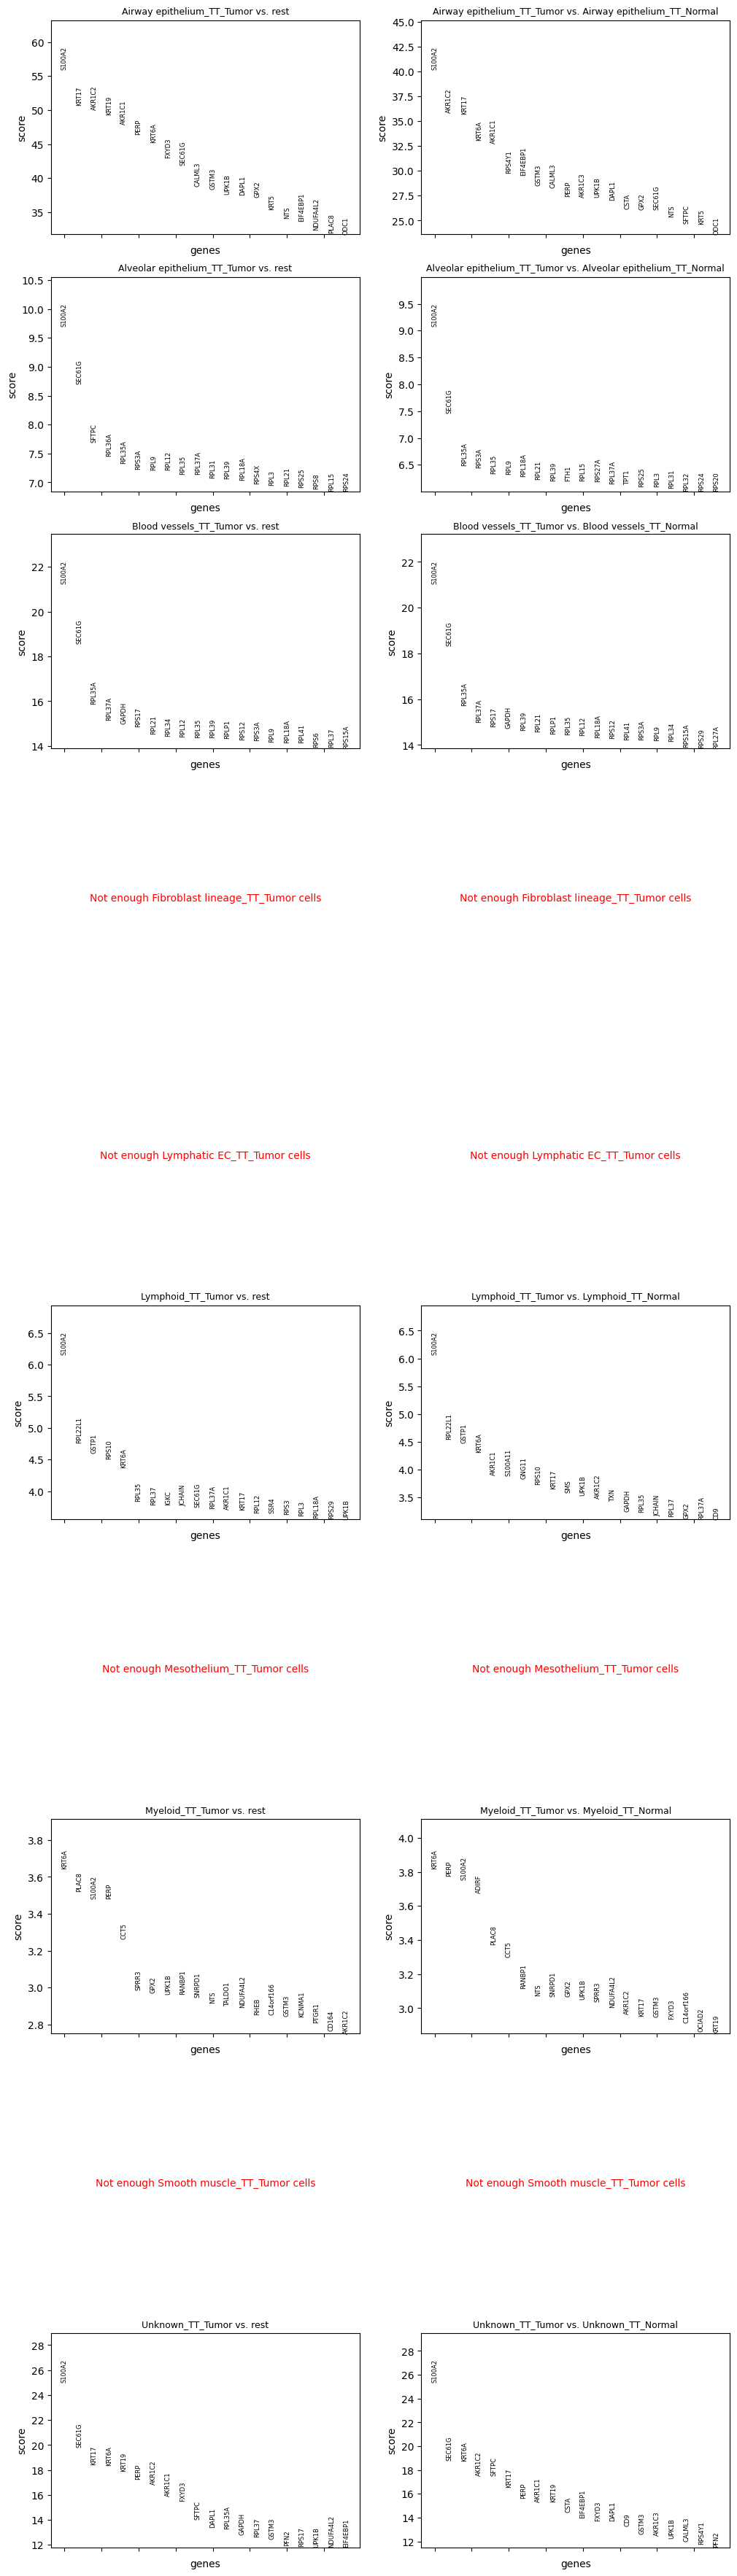

In [78]:
fig, axs = plt.subplots(num_types, 2, figsize=(12, 4.5*num_types))

n_genes = 20
for i, type in enumerate(types):
    tumor_tumor = type + '_TT_Tumor'
    normal_tumor = type + '_TT_Normal'
    titlesize = 9
    fontsize = 6

    
    cond_plot(adata, tumor_tumor, valid_types, n_genes=n_genes,
                     ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                     fontsize=fontsize, titlesize=titlesize)
    cond_plot(adata, tumor_tumor, valid_types, n_genes=n_genes, ax= axs[i, 1],
                            key=f"w_pair_{type}_differ", show=False,
                     fontsize=fontsize, titlesize=titlesize)

# Display the entire figure with all plots
plt.show()

In [ ]:
fig, axs = plt.subplots(num_types, 3, figsize=(17, 4.5*num_types))

n_genes = 20
for i, type in enumerate(types):
    normal_healthy = type + '_HT_Normal'
    tumor_tumor = type + '_TT_Normal'
    titlesize = 9
    fontsize = 6

    
    cond_plot(adata, normal_healthy, valid_types, n_genes=n_genes,
                     ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                     fontsize=fontsize, titlesize=titlesize)
    cond_plot(adata, normal_tumor, valid_types, n_genes=n_genes,
                            ax= axs[i, 1], sharey=False, key="wilcoxon", show=False,
                     fontsize=fontsize, titlesize=titlesize)
    cond_plot(adata, normal_tumor, valid_types, n_genes=n_genes, ax= axs[i, 2],
                            key=f"w_pair_{type}_normal", show=False,
                     fontsize=fontsize, titlesize=titlesize)

# Display the entire figure with all plots
plt.show()

## Heatmaps

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata_normal_tumor, show_gene_labels=True)

## DE

### **edgeR**: Pseudo-bulk

If the data you are working with does not have replicates, it could be beneficial to create multiple (e.g. 2-3) pseudobulks per patient to account for patient variability. Here we chose to create 3 pseudobulk per patient because we dont have replicates.

We strongly recommend to read this guide https://f1000research.com/articles/9-1444 on design matrices.

Regardless of whether we want to run the analysis only on a few cell subpopulations and fit a model for each one of them separately or fit one model for all of them, we first need to prepare the data, define a function to create pseudobulks and run the edgeR pipeline. First, let’s prepare the data.

Since we need to create pseudobulks for each patient-condition combination, we first need to create such a column by concatenating replicate and label.

We need to clean up the cell type names, i.e. replace spaces with underscores and remove + symbols, to avoid Python to R conversion issues.

In [1]:
# We create a backup so that the names are consistent with our tutorial
adata_backup = adata.copy()

NameError: name 'adata' is not defined

In [ ]:
adata.obs = pd.get_dummies(adata.obs, columns=['leiden'])

We need 4 keys in `.obs`.
- 'sample' is combination of the replicate and label
- 'label' is the condition to check differential expression against
- 'replicate' is the experiment, (because we could have more than for the same subject, but we don't and we will simulate them)
- 'cell_type' is the cell type for which we could iterate to do various DE

In [28]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["sample"], adata.obs["final_pred"])
]
adata_raw.obs.groupby('sample').count()

5328     patient_41_normal_adjacent_Tumor
6046     patient_41_normal_adjacent_Tumor
13121    patient_45_normal_adjacent_Tumor
21763      patient_32_tumor_primary_Tumor
21858      patient_32_tumor_primary_Tumor
                       ...               
42936      patient_43_tumor_primary_Tumor
43031      patient_43_tumor_primary_Tumor
50547      patient_46_tumor_primary_Tumor
52728      patient_46_tumor_primary_Tumor
53066      patient_46_tumor_primary_Tumor
Name: sample, Length: 1844, dtype: object

In [70]:
type_label = "leiden"
adata.obs[type_label] = [ct.replace(" ", "_") for ct in adata.obs[type_label]]
adata.obs[type_label] = [ct.replace("+", "") for ct in adata.obs[type_label]]

We need to set categorical metadata to be indeed categorical to create pseudobulks.

In [71]:
adata.obs["sample"] = adata.obs["sample"].astype("category")
adata.obs[type_label] = adata.obs[type_label].astype("category")

Now, let’s define the function we need to aggregate single cells into pseudo-replicates:

- `aggregate_and_filter` is a function that creates an AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData object. Here we also filter out donors that have fewer than 30 cells for the specified population. 
  - Since we want to obtain the genes differentially expressed for every cluster proposed by our leiden algorithm.
We will be changing th design of our function so that the condition is
being or not in the cluster. And we only have one type of cell. Which is a constant everywhere.

- by changing the `replicates_per_patient` parameter, several (n) pseudo-replicates can be created for each sample; cells are then split into n subsets of roughly equal sizes.


In [80]:
NUM_OF_CELL_PER_DONOR = 20
import random

def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="leiden_0",
    cell_identity_key="constant",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=2,
):
    obs_to_keep = list(set(obs_to_keep) | set([donor_key, condition_key]))
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"{donor}_{i}"] = df_donor.loc[donor]
                print(df.drop(columns=adata_cell_pop.var_names))
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [ ]:
aggregate_and_filter(adata, 'constant')

We also need to define a separate function to fit an edgeR GLM:

- `fit_model` takes a `SingleCellExperiment` object as input, creates the design matrix and outputs the fitted GLM. We also output the edgeR object of class DGEList to do some exploratory data analysis (EDA).


In [75]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$label)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(colData(adata_)$label, ".", colData(adata_)$cell_type)
    # replicate <- colData(adata_)$replicate
    # create a design matrix: even though we have multiple donors we dont have normal and lunk form the same donor
    # so we dont consider this becuase it would lead to correlations in the coeffcients that would reduce the ranl
    # of the matrix
    design <- model.matrix(~ 0 + group)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

Now we defined all the functions we need, so we can proceed with creating pseudobulks. We might want to look at available metadata later and therefore keep it in the AnnData object.

In [106]:
obs_to_keep = ["tissue", 'condition', "sample"]

We need to pass the raw counts to edgeR. Hence, we set .X to the counts layer to ensure the pseudo-replicates are created for raw counts.

In [79]:
adata.X = adata.layers["counts"].copy()

Before creating the pseudobulks we need to hot-encode the leiden clsuters so each
one is compared to the background. And also add the constant column as an atavism.

In [92]:
# adata.obs = pd.get_dummies(adata.obs, columns=['leiden'])
adata.obs['constant'] = 'tumor'
adata.obs['constant'] = adata.obs['constant'].astype('category')

In [127]:
adata

AnnData object with n_obs × n_vars = 2401 × 28863
    obs: 'dataset', 'sample', 'accession', 'sex', 'condition', 'origin', 'patient', 'tissue', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'Level_2_transfered_label', 'final_pred', 'leiden_0', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'leiden_6', 'constant', 'leiden'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors', 'leiden', 'umap', 'Level_2_transfered_label_colors', 'leiden_colors', 'log1p', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

Next, we create the AnnData object with pseudobulks. We do it concurrently as the procces of the
aggreggated sum does take a while.

HERE we execute it so that we pass a different condition for every cluster.

In [107]:
import concurrent.futures
# Process the remaining cell types concurrently
conditions = [f'leiden_{i}' for i in range(0,7)]

def process_cell_type(adata, condition, obs_to_keep, replicates_per_patient):
    # print(f'Processing {cell_type}...')
    return aggregate_and_filter(adata, 'tumor', condition_key=condition,
                                obs_to_keep=obs_to_keep,
                                replicates_per_patient=replicates_per_patient)


adata_pb = None
with concurrent.futures.ProcessPoolExecutor() as executor:
    futures = []
    for condition in conditions:
        print(f'Processing {condition}...')
        future = executor.submit(process_cell_type, adata, condition,
                               obs_to_keep, 3)
        futures.append(future)

    for i, future in enumerate(concurrent.futures.as_completed(futures)):
        print(f'Finished {conditions[i]}...')
        adata_leiden_cluster = future.result()
        
        if i==0:
            adata_pb = adata_leiden_cluster
        else:
            adata_pb = adata_pb.concatenate(adata_leiden_cluster)

adata_pb

Processing leiden_0...
Processing leiden_1...
Processing leiden_2...
Processing leiden_3...
Processing leiden_4...
Processing leiden_5...
Processing leiden_6...


/tmp/ipykernel_137001/3303381390.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
/tmp/ipykernel_137001/3303381390.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
/tmp/ipykernel_137001/3303381390.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_by_donor = adata_cell_pop.obs.group

/tmp/ipykernel_137001/3303381390.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)
/tmp/ipykernel_137001/3303381390.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_by_donor = adata_cell_pop.obs.groupby([donor_

/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)
/tmp/ipykernel_137001/3303381390.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)
/tmp/ipykernel_137001/3303381390.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          leiden_6 condition   sample tissue
NSCLC-9_0    False     NSCLC  NSCLC-9   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample tissue leiden_1
NSCLC-9_0     NSCLC  NSCLC-9   lung     True


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample leiden_2 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample leiden_3 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample leiden_4 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample leiden_0 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition leiden_5   sample tissue
NSCLC-9_0     NSCLC    False  NSCLC-9   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          leiden_6 condition   sample tissue
NSCLC-9_0    False     NSCLC  NSCLC-9   lung
NSCLC-9_1    False     NSCLC  NSCLC-9   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample tissue leiden_1
NSCLC-9_0     NSCLC  NSCLC-9   lung     True
NSCLC-9_1     NSCLC  NSCLC-9   lung     True


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample leiden_2 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung
NSCLC-9_1     NSCLC  NSCLC-9    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample leiden_3 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung
NSCLC-9_1     NSCLC  NSCLC-9    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample leiden_4 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung
NSCLC-9_1     NSCLC  NSCLC-9    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition leiden_5   sample tissue
NSCLC-9_0     NSCLC    False  NSCLC-9   lung
NSCLC-9_1     NSCLC    False  NSCLC-9   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample leiden_0 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung
NSCLC-9_1     NSCLC  NSCLC-9    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          leiden_6 condition   sample tissue
NSCLC-9_0    False     NSCLC  NSCLC-9   lung
NSCLC-9_1    False     NSCLC  NSCLC-9   lung
NSCLC-9_2    False     NSCLC  NSCLC-9   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           leiden_6 condition    sample tissue
NSCLC-9_0     False     NSCLC   NSCLC-9   lung
NSCLC-9_1     False     NSCLC   NSCLC-9   lung
NSCLC-9_2     False     NSCLC   NSCLC-9   lung
NSCLC-10_0    False     NSCLC  NSCLC-10   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample tissue leiden_1
NSCLC-9_0     NSCLC  NSCLC-9   lung     True
NSCLC-9_1     NSCLC  NSCLC-9   lung     True
NSCLC-9_2     NSCLC  NSCLC-9   lung     True


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition leiden_5   sample tissue
NSCLC-9_0     NSCLC    False  NSCLC-9   lung
NSCLC-9_1     NSCLC    False  NSCLC-9   lung
NSCLC-9_2     NSCLC    False  NSCLC-9   lung
          condition   sample leiden_3 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung
NSCLC-9_1     NSCLC  NSCLC-9    False   lung
NSCLC-9_2     NSCLC  NSCLC-9    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)
/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample leiden_4 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung
NSCLC-9_1     NSCLC  NSCLC-9    False   lung
NSCLC-9_2     NSCLC  NSCLC-9    False   lung
          condition   sample leiden_0 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung
NSCLC-9_1     NSCLC  NSCLC-9    False   lung
NSCLC-9_2     NSCLC  NSCLC-9    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)
/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


          condition   sample leiden_2 tissue
NSCLC-9_0     NSCLC  NSCLC-9    False   lung
NSCLC-9_1     NSCLC  NSCLC-9    False   lung
NSCLC-9_2     NSCLC  NSCLC-9    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           leiden_6 condition    sample tissue
NSCLC-9_0     False     NSCLC   NSCLC-9   lung
NSCLC-9_1     False     NSCLC   NSCLC-9   lung
NSCLC-9_2     False     NSCLC   NSCLC-9   lung
NSCLC-10_0    False     NSCLC  NSCLC-10   lung
NSCLC-10_1    False     NSCLC  NSCLC-10   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           condition    sample leiden_3 tissue
NSCLC-9_0      NSCLC   NSCLC-9    False   lung
NSCLC-9_1      NSCLC   NSCLC-9    False   lung
NSCLC-9_2      NSCLC   NSCLC-9    False   lung
NSCLC-10_0     NSCLC  NSCLC-10    False   lung
           condition    sample tissue leiden_1
NSCLC-9_0      NSCLC   NSCLC-9   lung     True
NSCLC-9_1      NSCLC   NSCLC-9   lung     True
NSCLC-9_2      NSCLC   NSCLC-9   lung     True
NSCLC-10_0     NSCLC  NSCLC-10   lung    False


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)
/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           condition    sample leiden_0 tissue
NSCLC-9_0      NSCLC   NSCLC-9    False   lung
NSCLC-9_1      NSCLC   NSCLC-9    False   lung
NSCLC-9_2      NSCLC   NSCLC-9    False   lung
NSCLC-10_0     NSCLC  NSCLC-10    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           condition    sample leiden_2 tissue
NSCLC-9_0      NSCLC   NSCLC-9    False   lung
NSCLC-9_1      NSCLC   NSCLC-9    False   lung
NSCLC-9_2      NSCLC   NSCLC-9    False   lung
NSCLC-10_0     NSCLC  NSCLC-10    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           condition leiden_5    sample tissue
NSCLC-9_0      NSCLC    False   NSCLC-9   lung
NSCLC-9_1      NSCLC    False   NSCLC-9   lung
NSCLC-9_2      NSCLC    False   NSCLC-9   lung
NSCLC-10_0     NSCLC    False  NSCLC-10   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           condition    sample leiden_4 tissue
NSCLC-9_0      NSCLC   NSCLC-9    False   lung
NSCLC-9_1      NSCLC   NSCLC-9    False   lung
NSCLC-9_2      NSCLC   NSCLC-9    False   lung
NSCLC-10_0     NSCLC  NSCLC-10    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           leiden_6 condition    sample tissue
NSCLC-9_0     False     NSCLC   NSCLC-9   lung
NSCLC-9_1     False     NSCLC   NSCLC-9   lung
NSCLC-9_2     False     NSCLC   NSCLC-9   lung
NSCLC-10_0    False     NSCLC  NSCLC-10   lung
NSCLC-10_1    False     NSCLC  NSCLC-10   lung
NSCLC-10_2    False     NSCLC  NSCLC-10   lung


Finished leiden_0...
           condition    sample leiden_4 tissue
NSCLC-9_0      NSCLC   NSCLC-9    False   lung
NSCLC-9_1      NSCLC   NSCLC-9    False   lung
NSCLC-9_2      NSCLC   NSCLC-9    False   lung
NSCLC-10_0     NSCLC  NSCLC-10    False   lung
NSCLC-10_1     NSCLC  NSCLC-10    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           condition    sample tissue leiden_1
NSCLC-9_0      NSCLC   NSCLC-9   lung     True
NSCLC-9_1      NSCLC   NSCLC-9   lung     True
NSCLC-9_2      NSCLC   NSCLC-9   lung     True
NSCLC-10_0     NSCLC  NSCLC-10   lung    False
NSCLC-10_1     NSCLC  NSCLC-10   lung    False


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           condition    sample leiden_0 tissue
NSCLC-9_0      NSCLC   NSCLC-9    False   lung
NSCLC-9_1      NSCLC   NSCLC-9    False   lung
NSCLC-9_2      NSCLC   NSCLC-9    False   lung
NSCLC-10_0     NSCLC  NSCLC-10    False   lung
NSCLC-10_1     NSCLC  NSCLC-10    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           condition leiden_5    sample tissue
NSCLC-9_0      NSCLC    False   NSCLC-9   lung
NSCLC-9_1      NSCLC    False   NSCLC-9   lung
NSCLC-9_2      NSCLC    False   NSCLC-9   lung
NSCLC-10_0     NSCLC    False  NSCLC-10   lung
NSCLC-10_1     NSCLC    False  NSCLC-10   lung
           condition    sample leiden_2 tissue
NSCLC-9_0      NSCLC   NSCLC-9    False   lung
NSCLC-9_1      NSCLC   NSCLC-9    False   lung
NSCLC-9_2      NSCLC   NSCLC-9    False   lung
NSCLC-10_0     NSCLC  NSCLC-10    False   lung
NSCLC-10_1     NSCLC  NSCLC-10    False   lung
           condition    sample leiden_3 tissue
NSCLC-9_0      NSCLC   NSCLC-9    False   lung
NSCLC-9_1      NSCLC   NSCLC-9    False   lung
NSCLC-9_2      NSCLC   NSCLC-9    False   lung
NSCLC-10_0     NSCLC  NSCLC-10    False   lung
NSCLC-10_1     NSCLC  NSCLC-10    False   lung


/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)
/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)
/tmp/ipykernel_137001/3303381390.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_donor = df_donor.groupby(donor_key).agg(agg_dict)


           condition    sample leiden_4 tissue
NSCLC-9_0      NSCLC   NSCLC-9    False   lung
NSCLC-9_1      NSCLC   NSCLC-9    False   lung
NSCLC-9_2      NSCLC   NSCLC-9    False   lung
NSCLC-10_0     NSCLC  NSCLC-10    False   lung
NSCLC-10_1     NSCLC  NSCLC-10    False   lung
NSCLC-10_2     NSCLC  NSCLC-10    False   lung


Finished leiden_1...


/tmp/ipykernel_137001/3605754491.py:28: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_leiden_cluster)


           condition    sample leiden_2 tissue
NSCLC-9_0      NSCLC   NSCLC-9    False   lung
NSCLC-9_1      NSCLC   NSCLC-9    False   lung
NSCLC-9_2      NSCLC   NSCLC-9    False   lung
NSCLC-10_0     NSCLC  NSCLC-10    False   lung
NSCLC-10_1     NSCLC  NSCLC-10    False   lung
NSCLC-10_2     NSCLC  NSCLC-10    False   lung


           condition    sample leiden_0 tissue
NSCLC-9_0      NSCLC   NSCLC-9    False   lung
NSCLC-9_1      NSCLC   NSCLC-9    False   lung
NSCLC-9_2      NSCLC   NSCLC-9    False   lung
NSCLC-10_0     NSCLC  NSCLC-10    False   lung
NSCLC-10_1     NSCLC  NSCLC-10    False   lung
NSCLC-10_2     NSCLC  NSCLC-10    False   lung


           condition    sample tissue leiden_1
NSCLC-9_0      NSCLC   NSCLC-9   lung     True
NSCLC-9_1      NSCLC   NSCLC-9   lung     True
NSCLC-9_2      NSCLC   NSCLC-9   lung     True
NSCLC-10_0     NSCLC  NSCLC-10   lung    False
NSCLC-10_1     NSCLC  NSCLC-10   lung    False
NSCLC-10_2     NSCLC  NSCLC-10   lung    False


       

/tmp/ipykernel_137001/3605754491.py:28: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_leiden_cluster)


Finished leiden_3...


/tmp/ipykernel_137001/3605754491.py:28: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_leiden_cluster)


Finished leiden_4...


/tmp/ipykernel_137001/3605754491.py:28: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_leiden_cluster)


Finished leiden_5...
Finished leiden_6...


/tmp/ipykernel_137001/3605754491.py:28: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_leiden_cluster)
/tmp/ipykernel_137001/3605754491.py:28: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_pb = adata_pb.concatenate(adata_leiden_cluster)


AnnData object with n_obs × n_vars = 42 × 28863
    obs: 'leiden_6', 'condition', 'sample', 'tissue', 'leiden_4', 'batch', 'leiden_2', 'leiden_0', 'leiden_1', 'leiden_3', 'leiden_5'

In [154]:
adata.uns['rank_genes_groups']

KeyError: 'rank_genes_groups'

In [156]:
lol = adata.uns['wilcoxon']['names']['1']

In [160]:
(lol == 'LGALS1').nonzero()

(array([0]),)